# The Customer Behaviour Trend Insights Report of Bay Wheel's Bike Service in the SF Bay Area


<span style="color: gray; font-size:1em;">Kolin Schunck</span>
<br><span style="color: gray; font-size:1em;">April 27, 2020</span>


## Investigation Overview

> The following slide deck provides insights into the User Bevahiour of the Bay Wheel's bike share system in the Bay Area of San Francisco. The main focus was on the time (month, weekday, hour), when bikes were in high demand with a comparison of two user groups, namely: Subscribers and Customers. More information about Bay Wheel's can be found below.


## Dataset Overview

> This document explores the Bay Wheel's trip data of bike rides for the FY2019. The variables include the trip start/end time, as well as additional features such as user type, and trip duration. The dataset was extracted from the following website: https://www.lyft.com/bikes/bay-wheels/system-data. 

## Bay Wheel's Bike Share System

Bay Wheels is a regional public bicycle sharing system in the San Francisco Bay Area, California operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. It was established as Bay Area Bike Share in August 2013. As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose. On June 28, 2017, the system officially re-launched as Ford GoBike in a partnership with Ford Motor Company. After Motivate's acquisition by Lyft, the system was subsequently renamed to Bay Wheels in June 2019. The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.

The bicycles are available 24 hours a day, seven days a week for periods ranging from a single ride (up to 30 minutes) to a day pass, in 30-minute increments, or customers can purchase an annual subscription which gives them unlimited rides up to 45-minutes in duration. Single rides cost USD2 per trip, day passes cost USD10 per day, and memberships cost USD15 per month or USD149 per year.

A reduced pricing option called "Bike Share for All" exists for users who qualify for CalFresh, the SFMTA's Lifeline pass, or PG & E's CARE discount. The reduced price is USD5/year for the first year and USD5/month in subsequent years. This membership option provides rides of 60 minutes without an additional charge. As of January 2018, around 15% of the membership of the bikeshare system used the Bike Share for All option.

In [1]:
# import all packages and set plots to be embedded inline
import requests, zipfile
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
from glob import glob
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe
df_clean = pd.read_csv('clean_master_file.csv')

In [3]:
# calculating percentage of each group on total bike rides:
count_of_rides_per_user_type = df_clean.groupby('user_type').size().reset_index(name='count')

count_of_rides_per_user_type['count']/len(df_clean)*100

0    19.378552
1    80.621448
Name: count, dtype: float64

## Trend Insight 1: Subscribers are the heavy-user group of the bike ride system

> Customers with a monthly membership ("Subscriber") make 81% of all customers in FY 2019 that used the system. 19% were casual riders ("Customer") using the bike share system ocasionally, upon demand.
> Casual riders ("Customer") continously increase in terms of absolute figures in FY 2019. Monthly membership users stayed on avg. relatively stable, with a sharp decline beginning in November. This is most likely b/c of the beginning of the winter season. Monthly subscribers then probably pause or cancel their membership and re-activate it once the winter season is over.

In [6]:
#Generate new fields for date from start_time and end_time
df_clean['start_time']=pd.to_datetime(df_clean['start_time'])
df_clean['end_time']=pd.to_datetime(df_clean['end_time'])

In [9]:
df_clean['start_time_year_month_renamed'] = df_clean['start_time'].dt.strftime('%y' + '-' + '%m')

In [11]:
user_type_count_per_year_df = df_clean.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

In [13]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

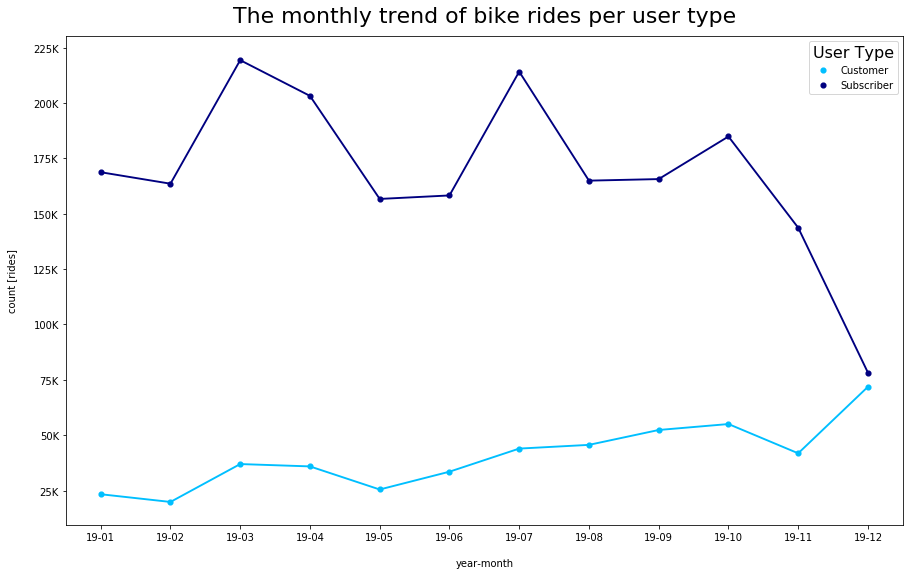

In [14]:
plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'navy', 'Customer':'deepskyblue'}
ax = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('monthly_trend_rides_user_groups.png')

## Trend Insight 2: Usage varies by user groups significantly

> Customers with a monthly subscription use the bike ride system for approx. 12 min. per bike ride on average. The surprising fact is that casual riders almost use the system twice as long, namely 23 min. The average distance also varies slightly, as casual riders ride on average 1.75 miles, whereas subscription members ride 1.25 on average. This confirms the overall findings that subscribers use the system to go to/from work, wherea casual riders could be tourists or others spending time in the SF Bay Area to explore certain areas of the city.

In [16]:
#Generate minutes for trip duration from duration_sec
df_clean['duration_min'] = df_clean['duration_sec']/60

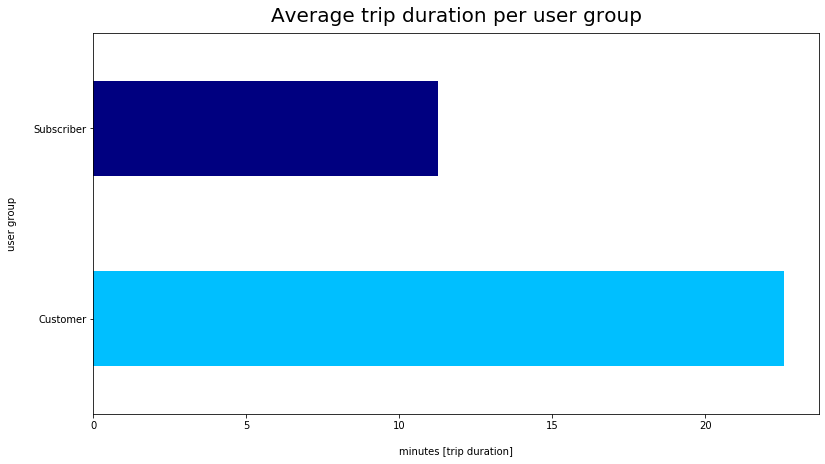

In [17]:
# average trip duration per user group
new_color=['deepskyblue', 'navy']
ax = df_clean.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user group', fontsize=20, y=1.015)
ax.set_ylabel('user group', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16)
plt.savefig('avg_trip_duration_user_group.png')

In [19]:
#Generate new fields for distance
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [20]:
df_clean['distance_km_estimates'] = df_clean.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df_clean['distance_miles_estimates'] = df_clean['distance_km_estimates']*0.621371

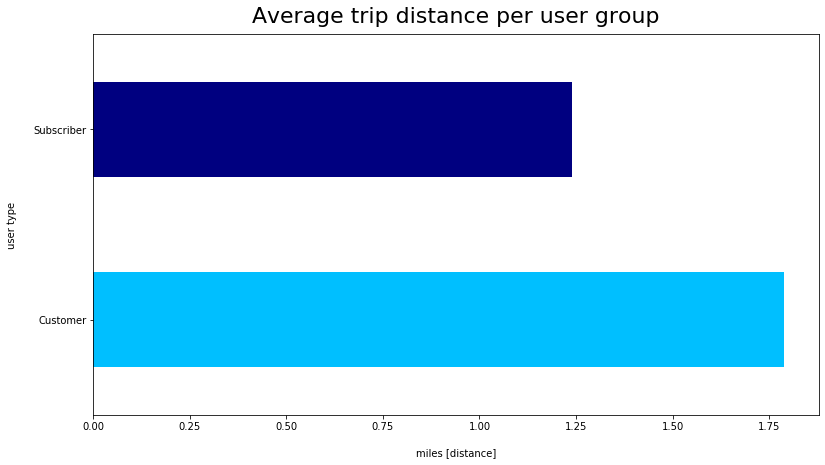

In [21]:
ax = df_clean.groupby('user_type')['distance_miles_estimates'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user group', fontsize=22, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('miles [distance]', labelpad=16)
plt.savefig('avg_trip_distance_user_group.png')

## Trend Insight 3: Subscribers are more active during weekdays, whereas casual riders show high activity both during weekdays and weekends

>#### Casual Riders use the bike sharing system more often on weekends:
 * weekdays: most bike rides hapen around 8-9am and 5-6pm with the peak on Fridays around 5pm
 * weekends: most bike rides happen between 10am - 8pm with the peak on Saturdays around 2pm

>#### Subscribers use the bike sharing system mainly on weekdays:
 * weekdays: most bike rides hapen around 8-9am and 5-6pm with the peak on Tuesdays around 8am
 * weekends: bikes are still rented but there is a significant drop in numbers of rented bikes throughout the entire weekends

In [23]:
df_clean['start_time_weekday_abbr']=df_clean['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df_clean['end_time_weekday_abbr']=df_clean['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

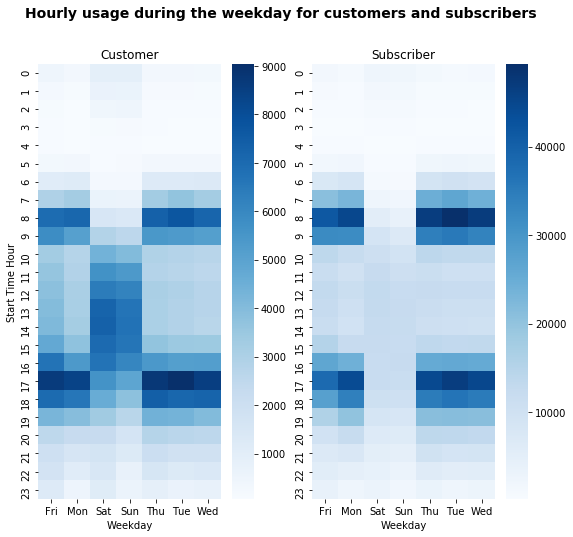

In [25]:
# setting the weekday order
df_clean['start_time_weekday'] = pd.Categorical(df_clean['start_time_weekday_abbr'], 
                                                categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                                ordered=True)
plt.figure(figsize=(9,8))
plt.suptitle('Hourly usage during the weekday for customers and subscribers', fontsize=14, fontweight='semibold')

# heatmap for customers
plt.subplot(1, 2, 1)
df_customer = df_clean.query('user_type == "Customer"').groupby(["start_time_hour", "start_time_weekday_abbr"])["bike_id"].size().reset_index()
df_customer = df_customer.pivot("start_time_hour", "start_time_weekday_abbr", "bike_id")
sns.heatmap(df_customer, cmap="Blues")

plt.title("Customer", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('Start Time Hour')

# heatmap for subscribers
plt.subplot(1, 2, 2)
df_subscriber = df_clean.query('user_type == "Subscriber"').groupby(["start_time_hour", "start_time_weekday_abbr"])["bike_id"].size().reset_index()
df_subscriber = df_subscriber.pivot("start_time_hour", "start_time_weekday_abbr", "bike_id")
sns.heatmap(df_subscriber, cmap="Blues")

plt.title("Subscriber", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('');

plt.savefig('hourly_usage_weekday_user_groups.png')

## Summary

> Renting a bike from Bay Wheel's bike service is a great way to move around the city or SF Bay area, either for pleasure or work. Two types of customer groups are identfied: (1) Subscribers and (2) Casual Riders. Subscribers use the service mainly for commuting to/from work, whereas Casual Riders are most likely tourists or occassional riders to use the service for exploring the Bay area. Further, subscribers represent the largest group (81%) who rent a bike during the weekdays mostly between 7am-9am as well as 4pm-6pm. There are also minor usages during lunch hours. The subscriber group should be handled with care by Bay Wheel's as they are the largest group, having a great impact on the overall business for the company.